In [1]:
using PyPlot, TimeIt, Distributions, Optim
import PyPlot
const plt = PyPlot
include("ZZ_subsampling.jl") 
include("ZZ_clustering.jl") 

ZZ_clustering (generic function with 5 methods)

In [2]:
function logistic_data(d, Nobs, p=0.1, δ=3, m=10) 
    X = rand(d, Nobs)
    X[:,1:m] = δ*rand(Normal(), d, m)
    y = rand(Binomial(1,p), Nobs)
    return X, y
end

logistic_data (generic function with 4 methods)

In [3]:
d, Nobs = 100, 500
σ = 2
p = 0.01
δ = 3
m = 20
X, y = logistic_data(d, Nobs, p, δ, m)
sum(y)

6

In [6]:
root = find_root(X, y, σ)
weights_CV = zeros(d, Nobs)
for n in 1:Nobs
    weights_CV[:,n] = [abs.(X[i,n])*norm(X[:,n]) for i in 1:d]
end

In [27]:
β_0 = copy(root)
mb_size = 10
A = eye(d)
replace = true
max_attempts = 10^8;

### Run stuff:

In [28]:
start = time()
s_iid, b_iid = ZZ_logistic(X, y, max_attempts, β_0, mb_size, root, σ, A, false, nothing, replace)
s_w, b_w = ZZ_logistic(X, y, max_attempts, β_0, mb_size, root, σ, A, false, abs.(X), replace)
print( round((time()-start)/60, 2), " minutes to run")

0.062% of switches accepted 
0.76% of switches accepted 
238.1 minutes to run

In [29]:
start = time()
s_CV_uw, b_CV_uw = ZZ_logistic(X, y, max_attempts, β_0, mb_size, root, σ, A, true, nothing, replace)
s_CV_w, b_CV_w = ZZ_logistic(X, y, max_attempts, β_0, mb_size, root, σ, A, true, weights_CV, replace)
print( round((time()-start)/60, 2), " minutes to run")

0.001% of switches accepted 
0.017% of switches accepted 
290.51 minutes to run

In [30]:
start = time()
# s_kmeans, b_kmeans = ZZ_clustering(X, y, max_attempts, β_0, mb_size, root, σ, A, "kmeans", false) 
s_sorted_uw, b_sorted_uw = ZZ_clustering(X, y, max_attempts, β_0, mb_size, root, σ, A, "sorted", false) 
s_sorted_w, b_sorted_w = ZZ_clustering(X, y, max_attempts, β_0, mb_size, root, σ, A, "sorted", true) 
print( round((time()-start)/60, 2), " minutes to run")

0.05% of switches accepted 
0.33% of switches accepted 
251.16 minutes to run

### Plot boxplots of ACFs:

In [41]:
N_samples = 10^4 
samples_CV_uw = extract_samples(s_CV_uw, b_CV_uw, b_CV_uw[end]/N_samples)
samples_CV_w = extract_samples(s_CV_w, b_CV_w, b_CV_w[end]/N_samples)
samples_iid = extract_samples(s_iid, b_iid, b_iid[end]/N_samples)
samples_w = extract_samples(s_w, b_w, b_w[end]/N_samples)
samples_sorted_uw = extract_samples(s_sorted_uw, b_sorted_uw, b_sorted_uw[end]/N_samples);
samples_sorted_w = extract_samples(s_sorted_w, b_sorted_w, b_sorted_w[end]/N_samples);

In [42]:
maxlag = 200
acfs = zeros(6, d, maxlag)
for dim in 1:d 
    acfs[1,dim,:] = acf(samples_CV_uw[dim,:], maxlag)
    acfs[2,dim,:] = acf(samples_CV_w[dim,:], maxlag)
    acfs[3,dim,:] = acf(samples_iid[dim,:], maxlag)
    acfs[4,dim,:] = acf(samples_w[dim,:], maxlag)
    acfs[5,dim,:] = acf(samples_sorted_uw[dim,:], maxlag)
    acfs[6,dim,:] = acf(samples_sorted_w[dim,:], maxlag)
end

In [43]:
acfs_CV_uw, acfs_CV_w, acfs_iid, acfs_w, acfs_sorted_uw, acfs_sorted_w = [], [], [], [], [], []
xt = []
for i in 1:20
    push!(acfs_CV_uw, acfs[1,:,i*10])
    push!(acfs_CV_w, acfs[2,:,i*10])
    push!(acfs_iid, acfs[3,:,i*10])
    push!(acfs_w, acfs[4,:,i*10])
    push!(acfs_sorted_uw, acfs[5,:,i*10])
    push!(acfs_sorted_w, acfs[6,:,i*10])
    if i%5 == 0 
        push!(xt, 10*i)
    else 
        push!(xt, "")
    end
end

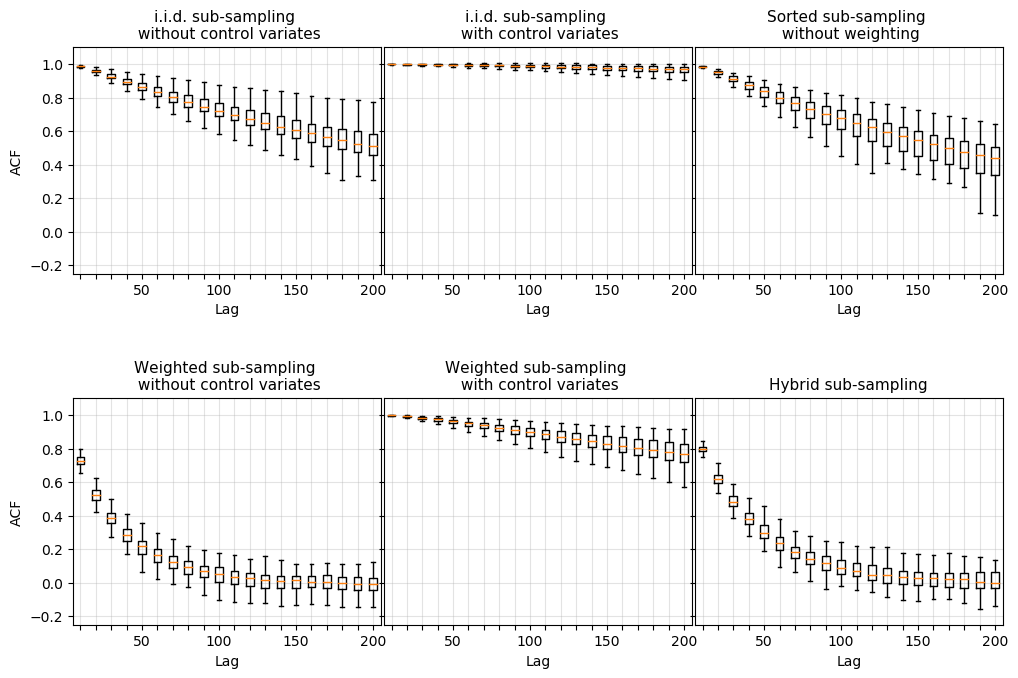

In [45]:
using PyPlot
fig = figure("pyplot_subplot_mixed", figsize=(12,7.5))

a, b = -0.25, 1.1
subplot(231)
boxplot(acfs_iid, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
ylabel("ACF", fontsize=10)
xticks(1:20, xt)
ylim([a,b])
title("i.i.d. sub-sampling \n without control variates", fontsize=11)

subplot(234)
boxplot(acfs_w, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:20, xt)
ylabel("ACF", fontsize=10)
ylim([a,b])
title("Weighted sub-sampling \n without control variates", fontsize=11)

subplot(233)
boxplot(acfs_sorted_uw, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:20, xt)
yticks(alpha=0)
ylim([a,b])
title("Sorted sub-sampling \n without weighting", fontsize=11)

subplot(232)
boxplot(acfs_CV_uw, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:20, xt)
yticks(alpha=0)
ylim([a,b])
title("i.i.d. sub-sampling \n with control variates", fontsize=11)

subplot(235)
boxplot(acfs_CV_w, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:20, xt)
yticks(alpha=0)
ylim([a,b])
title("Weighted sub-sampling \n with control variates", fontsize=11)

subplot(236)
boxplot(acfs_sorted_w, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
xticks(1:20, xt)
yticks(alpha=0)
ylim([a,b])
title("Hybrid sub-sampling", fontsize=11)

subplots_adjust(wspace=0.01, hspace=0.55)
plt.savefig("ACF_d100_N500_p001_delta3_m10.pdf", format="pdf", dpi=10000, bbox_inches="tight")